In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gc

In [6]:
!ls

drive  sample_data


In [15]:
df = pd.read_csv(
    'drive/MyDrive/Network_Analysis/gowiththeflow_20190826.csv',
    header = 0, 
    names= ['ts', 'src', 'dst', 'port', 'bytes']
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105747729 entries, 0 to 105747728
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ts      int64 
 1   src     object
 2   dst     object
 3   port    int64 
 4   bytes   int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ GB


We create extra features to make it more convenient to do certain filters such as "inbound traffic" and "outbound traffic"



In [16]:
def is_internal(s):
    return s.str.startswith(('12.', '13.', '14.')) 

df['src_int'] = is_internal(df['src'])
df['dst_int'] = is_internal(df['dst'])

df['ts']      = pd.to_datetime(df.ts, unit='ms')
df['hour']    = df.ts.dt.hour.astype('uint8')
df['minute']  = df.ts.dt.minute.astype('uint8')
df['port']    = df['port'].astype('uint8')
df.head()

,ts,src,dst,port,bytes,src_int,dst_int,hour,minute
0,2020-01-06 16:00:00.005,16.79.101.100,12.48.65.39,92,11895,False,True,16,0
1,2020-01-06 16:00:00.007,18.43.118.103,14.51.30.86,27,898,False,True,16,0
2,2020-01-06 16:00:00.011,15.71.108.118,14.50.119.33,57,7496,False,True,16,0
3,2020-01-06 16:00:00.012,14.33.30.103,15.24.31.23,115,20979,True,False,16,0
4,2020-01-06 16:00:00.012,18.121.115.31,13.56.39.74,92,8620,False,True,16,0


We convert the `src` and `dst` as categorical to save on memory.



In [17]:
all_ips = set(df['src'].unique()) | set(df['dst'].unique())
print('Unique src:', df['src'].nunique())
print('Unique dst:', df['dst'].nunique())
print('Total Unique IPs:', len(all_ips))

ip_type = pd.CategoricalDtype(categories=all_ips)
df['src'] = df['src'].astype(ip_type)
df['dst'] = df['dst'].astype(ip_type)
gc.collect()
df.info()

Unique src: 6171
Unique dst: 6005
Total Unique IPs: 6177
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105747729 entries, 0 to 105747728
Data columns (total 9 columns):
 #   Column   Dtype         
---  ------   -----         
 0   ts       datetime64[ns]
 1   src      category      
 2   dst      category      
 3   port     uint8         
 4   bytes    int64         
 5   src_int  bool          
 6   dst_int  bool          
 7   hour     uint8         
 8   minute   uint8         
dtypes: bool(2), category(2), datetime64[ns](1), int64(1), uint8(3)
memory usage: 2.5 GB


In [18]:
blacklist_ips = []
answers = []

**Question 1: Discover Data Exfiltration 1**

Our intellectual property is leaving the building in large chunks. A machine inside is being used to send out all of our widget designs. One host is sending out much more data from the enterprise than the others. What is its IP?

This is straightforward. We get the sources with the most outbound traffic in our network.


In [19]:
src_bytes_out = df[df['src_int'] & ~df['dst_int']]\
  .groupby('src')\
  .bytes.sum()\
  .pipe(lambda x: x[x > 0])\
  .sort_values(ascending=False)

src_bytes_out.to_frame().head()

,bytes
src,
13.37.84.125,10625497574
13.48.72.30,1727525696
14.51.75.107,1656207638
14.51.30.86,1647330708
12.59.25.34,1617316039


Text(0.5, 0, 'total outbound bytes')

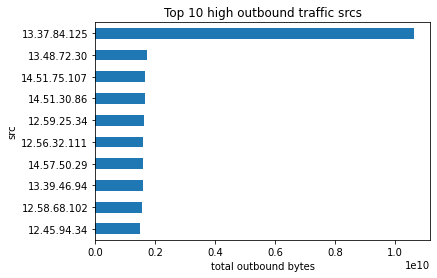

In [20]:
src_bytes_out.head(10)\
    .sort_values()\
    .plot.barh(title='Top 10 high outbound traffic srcs')\
    .set_xlabel('total outbound bytes')

Text(10625497574, 100, '13.37.84.125')

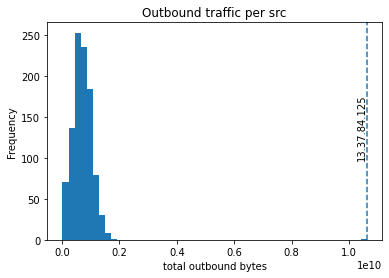

In [21]:
ax = src_bytes_out\
  .plot.hist(bins=50, title='Outbound traffic per src')

ax.set_xlabel('total outbound bytes')
_ = ax.axvline(src_bytes_out.iloc[0], linestyle='--')
plt.text(src_bytes_out.iloc[0], 100, '13.37.84.125', rotation=90, horizontalalignment='right')

**Question 2: Discover Data Exfiltration 2**

Another attacker has a job scheduled that export the contents of our internal wiki. One host is sending out much more data during off hours from the enterprise than the others, different from the host in the Question 1. What is its IP?

We look for the `src` that sends much more data outbound during off hours. To do this we first have to identify which are the off hours. From the plot below, we see regular office hours are between 16:00 to 23:00. So we filter for 0:00 to 16:00.

Text(0, 0.5, 'Connection counts')

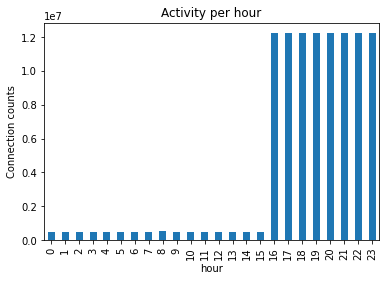

In [22]:
df.groupby('hour').size()\
  .plot.bar(title='Activity per hour')\
  .set_ylabel('Connection counts')

In [23]:
off_hours_activity = df[
    ~df['src'].isin(blacklist_ips)          # Not including previous answers
    & df['src_int'] & ~df['dst_int']        # Outbound
    & (df['hour'] >= 0) & (df['hour'] < 16) # Off hours
].groupby('src')\
  .bytes.sum()\
  .sort_values(ascending=False)\
  .where(lambda x: x > 0)

off_hours_activity.head()

src
13.37.84.125    731158032.0
12.55.77.96     289566918.0
13.48.72.30     120862595.0
14.51.30.86     116752466.0
12.59.25.34     115533918.0
Name: bytes, dtype: float64

Text(0.5, 0, 'total outbound bytes')

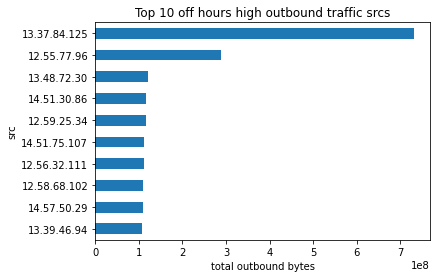

In [24]:
off_hours_activity.head(10)\
    .sort_values()\
    .plot.barh(title='Top 10 off hours high outbound traffic srcs')\
    .set_xlabel('total outbound bytes')

Text(731158032.0, 40, '12.55.77.96')

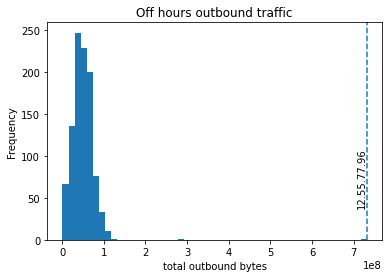

In [25]:
ax = off_hours_activity.plot.hist(bins=50, title='Off hours outbound traffic')
ax.set_xlabel('total outbound bytes')
_ = ax.axvline(off_hours_activity.iloc[0], linestyle='--')
plt.text(off_hours_activity.iloc[0], 40, '12.55.77.96', rotation=90, horizontalalignment='right')

Looking only at off hour traffic is important because this might not be something that we would detect if we only looked at overall outbound traffic.

Text(1033651932, 100, '12.55.77.96')

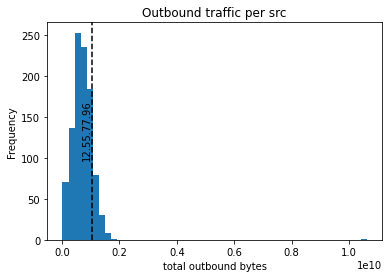

In [26]:
ax = src_bytes_out\
  .plot.hist(bins=50, title='Outbound traffic per src')

ax.set_xlabel('total outbound bytes')
_ = ax.axvline(src_bytes_out.loc['12.55.77.96'], color='k', linestyle='--')
plt.text(src_bytes_out.loc['12.55.77.96'], 100, '12.55.77.96', rotation=90, horizontalalignment='right')

In [27]:
#TEST
df[~df['src_int']][['src', 'dst', 'port']]

,src,dst,port
0,16.79.101.100,12.48.65.39,92
1,18.43.118.103,14.51.30.86,27
2,15.71.108.118,14.50.119.33,57
4,18.121.115.31,13.56.39.74,92
5,16.108.75.29,14.34.34.69,65
...,...,...,...
105696547,16.69.70.57,13.38.62.122,37
105696548,19.85.110.114,14.36.39.68,56
105696550,18.86.88.110,12.55.116.41,65
105696554,15.45.117.87,12.56.77.107,25
